In [56]:
# Yahoo site로 부터 대형주 종목 데이터를 수집하여 포트폴리오를 최적화한다
#
# 사용법 :
# 1. collectData() : Yahoo 사이트로부터 데이터를 수집하여 파일에 저장한다.
# 2. rv, C = makeRtnVol() : 저장된 데이터를 읽어서 수익률-변동성과 공분산 행렬을 계산한다.
# 3. plotPortfolio(rv) : 수익률-변동성 공간에 종목의 위치를 표시한다.
# 4. a = optPortfolio(rv, C) : 포트폴리오를 최적화한다. 종목별 비중과 성과를 확인한다.
# 5. plotPortfolio(a) : 수익률-변동성 공간에 최적 포트폴리오 위치를 표시한다.
# ------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from MyUtil.YahooData import getStockDataYahoo

# plot에서 한글 처리를 위해 아래 폰트를 사용한다
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

stocks = {'005380':'현대차', '000660':'SK하이닉스', '015760':'한국전력',
          '005490':'POSCO', '035420':'NAVER', '017670':'SK텔레콤', '012330':'현대모비스',
          '055550':'신한지주', '000270':'기아차', '105560':'KB금융', '051910':'LG화학',
          '034220':'LG디스플레이', '066570':'LG전자',
          '086790':'하나금융지주', '009540':'현대중공업', '023530':'롯데쇼핑', '030200':'KT',
          '024110':'기업은행', '096770':'SK이노베이션', '006400':'삼성SDI', '004020':'현대제철',
          '010130':'고려아연', '035250':'강원랜드', '011170':'롯데케미칼', '010950':'S-OIL',
          '010140':'삼성중공업', '000720':'현대건설', '036460':'한국가스공사',
          '001040':'CJ', '036570':'엔씨소프트', '009150':'삼성전기', '078930':'GS',
          '008770':'호텔신라', '047050':'대우인터내셔널', '006800':'대우증권', '003490':'대한항공',
          '034020':'두산중공업', '000210':'대림산업', '042670':'두산인프라코어', '000080':'하이트진로',
          '006360':'GS건설', '012450':'삼성테크윈'}

# Yahoo site로부터 대형주 종목 데이터를 수집한다
# 수정주가를 반영하여 삼성전자 주가 데이터를 수집한다. 가끔 안들어올 때가 있어서 10번 시도한다.
def collectData(startDate="2007-01-01"):
    n = 1
    for code in stocks.keys():
        # Yahoo site로부터 대형주 종목 데이터를 수집한다
        s = getStockDataYahoo(code + '.KS', start=startDate)
        print("%d) %s (%s.KS)가 수집되었습니다." % (n, stocks[code], code))
    
        # 수집한 데이터를 파일에 저장한다.
        s.to_pickle('StockData/' + code + '.KS')
        n += 1

# 저장된 주가 데이터를 읽어와서 종목 별로 연평균 수익률, 변동성 Sharp ratio를 계산한다
def makeRtnVol():
    rtnVol = pd.DataFrame(columns=['name', 'rtn', 'vol', 'sr'])
    rawRtn = pd.DataFrame()
    n = 0
    for code in stocks.keys():
        # 저장된 주가 데이터를 읽어온다
        file = code + '.KS'
        s = pd.read_pickle('StockData/' + file)
        s = s.dropna()

        # 일일 수익률을 계산한다.
        s[stocks[code]] = np.log(s.Close) - np.log(s.Close.shift(1))
        s = s.dropna()
        
        # 종목별 수익률로 한 데이터프레임에 모은다
        # 이 결과는 Covariance matrix 계산에 사용된다
        rawRtn = rawRtn.join(pd.DataFrame(s[stocks[code]]), how='outer')
        
        # 일일 수익률로 연평균 수익률, 연간 변동성, Sharp ratio를 계산한다.
        yRtn = np.mean(s[stocks[code]]) * 252
        yVol = np.std(s[stocks[code]]) * np.sqrt(252)
        sr = yRtn / yVol
        
        # 계산 결과를 data frame에 저장한다
        rtnVol.loc[n] = [stocks[code], yRtn, yVol, sr]
        n += 1
    
    rawRtn = rawRtn.dropna()
    return rtnVol, rawRtn.cov()

# 위험-수익률 공간에 각 종목을 배치한다.
# Yahoo 데이터가 정확하다고 가정함. 실제는 잘못된 값을 갖는 경우도 있으므로 데이터 전처리 과정이 필요함.
def plotPortfolio(p):
    fig, ax = plt.subplots(figsize=(20, 12))
    for row in p.itertuples():
        # sr이 음수이면 0.001로 설정한다
        if row.sr < 0:
            sr = 0.001
        else:
            sr = row.sr
            
        # 해당 종목을 배치한다. 원의 크기는 Sharp ratio로 한다.
        ax.scatter(row.vol, row.rtn, marker='o', alpha=0.5, s=sr * 5000)
        ax.annotate(row.name, (row.vol, row.rtn))

    ax.set_xlabel('변동성 (위험)')
    ax.set_ylabel('수익률')

# 포트폴리오 최적화를 위한 목표함수. Sharp Ratio를 최대화한다.
def targetFunc(w, *args):
    rtn = args[0]
    cm = args[1] #공분산매트릭스->2차원(공분산을 나타내므로 대각선기준으로 대칭)
    reg = args[2]

    portRtn = np.dot(w, rtn)
    portVol = np.sqrt(np.dot(w, np.dot(cm, w.T))) * np.sqrt(252) 
    SR = portRtn/portVol - reg * np.sum(w ** 2) #기존 SR-페널티/페널티의 역할: w편차가 크면 SR이 커지지 않도록
    return (-1) * portRtn / portVol #max 코딩위해 부호 바꿔줌

# 제한 조건. Weight의 총합 = 1.0
def constraint1(w):
    return np.sum(w) - 0.0

# 포트폴리오를 최적화한다.
# reg : Regularization constant
def optPortfolio(rv, C, reg=100, opt=True):
    # Weight 행렬을 균등하게 설정한다.
    W = np.ones(len(rv)) * 1/len(rv)
    R = rv.rtn.values
        
    if opt:
        # 최적 포트폴리오의 비율 (W)을 계산한다
        bnds = ((-1.0, +1.0),) * len(W)
        cons = {'type' : 'eq', 'fun' : constraint1}
        p = optimize.minimize(fun=targetFunc, x0=W, args=(R, C, reg), method='SLSQP', bounds=bnds, constraints=cons) 
                                #목표함수명, 초기값, 목표함수로 전달될 값(args)
        #print(p)
        
        # 포트폴리오 최적 비율
        W = p.x

    portRtn = np.dot(W, R) #최종포트폴리오 수익률
    portVol = np.sqrt(np.dot(W, np.dot(C, W.T))) * np.sqrt(252)
    rv['weight'] = W
    
    # weight의 Bar plot을 그린다
    plt.figure(figsize=(12, 6))
    x = range(1, len(W) + 1)
    ax = rv['weight'].plot(kind='bar', width=0.8, alpha=0.5)
    ax.set_title("Portfolio Weights")
    ax.set_xlabel("종목")
    ax.set_ylabel("Wehghts")
    ax.set_xticklabels(x)
    
    labels = rv['name']
    for p, i in zip(ax.patches, x):
        ax.annotate(labels[i-1], (p.get_x() * 1.005, p.get_height() * 1.005))
    
    # 최적 포트폴리오 성과를 기록해 둔다
    ret = rv.copy()
    ret.loc[len(rv)] = ('maxSR', portRtn, portVol, portRtn / portVol, 0)
    
    # 최적 포트폴리오 성과를 출력한다.
    print()
    print("* 포트폴리오 수익률 = %.2f (%s)" % (portRtn * 100, '%'))
    print("* 포트폴리오 변동성 = %.2f (%s)" % (portVol * 100, '%'))
    print("* Sharp Ratio = %.2f" % (portRtn / portVol))
    
    return ret
    
#rv, C = makeRtnVol()

In [57]:
rtn,C=makeRtnVol() #수익률변동성, 공분산행렬
print(rtn) #연평균수익률, 연평균변동성, 
#샤프지수(SR)=수익률/변동성 , 샤프지수 커지도록(수익률 클수록, 변동성은 작을수록 좋음)
#위험조정수익률


       name       rtn       vol        sr
0       현대차  0.068448  0.371064  0.184463
1    SK하이닉스  0.077177  0.458435  0.168349
2      한국전력 -0.007090  0.303762 -0.023340
3     POSCO  0.017288  0.340827  0.050723
4     NAVER  0.135453  0.413023  0.327956
5     SK텔레콤  0.060193  0.252257  0.238619
6     현대모비스  0.085617  0.360533  0.237474
7      신한지주  0.011235  0.338703  0.033172
8       기아차  0.097751  0.393640  0.248326
9      KB금융  0.014700  0.358154  0.041045
10     LG화학  0.201457  0.422962  0.476300
11  LG디스플레이 -0.018322  0.396150 -0.046251
12     LG전자  0.026057  0.376853  0.069144
13   하나금융지주  0.002816  0.414221  0.006798
14    현대중공업  0.048032  0.481385  0.099778
15     롯데쇼핑 -0.051836  0.360968 -0.143603
16       KT -0.009433  0.233913 -0.040328
17     기업은행  0.010259  0.362589  0.028294
18  SK이노베이션  0.031632  0.425698  0.074306
19    삼성SDI  0.113228  0.400865  0.282459
20     현대제철  0.046762  0.407269  0.114819
21     고려아연  0.149441  0.440781  0.339038
22     강원랜드  0.067297  0.338811  0

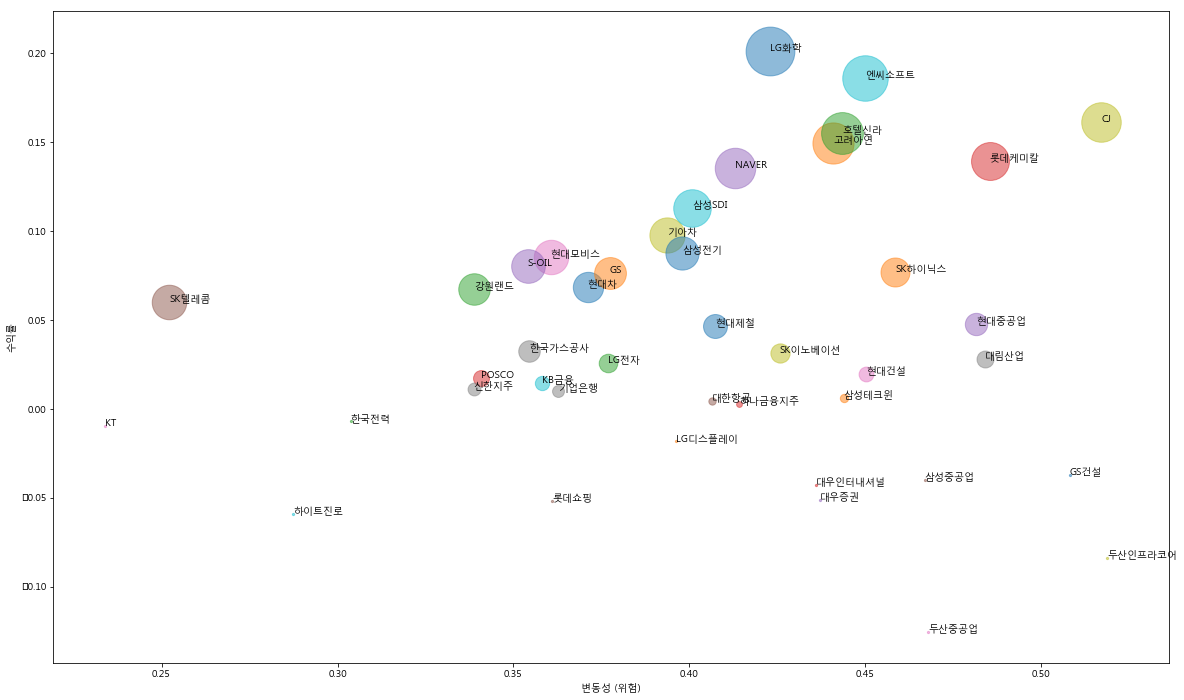

In [58]:
plotPortfolio(rtn)


* 포트폴리오 수익률 = 191.99 (%)
* 포트폴리오 변동성 = 146.31 (%)
* Sharp Ratio = 1.31


,name,rtn,vol,sr,weight
0,현대차,0.068448,0.371064,0.184463,1.000000
1,SK하이닉스,0.077177,0.458435,0.168349,1.000000
2,한국전력,-0.007090,0.303762,-0.023340,-1.000000
3,POSCO,0.017288,0.340827,0.050723,-1.000000
4,NAVER,0.135453,0.413023,0.327956,0.833189
5,SK텔레콤,0.060193,0.252257,0.238619,1.000000
6,현대모비스,0.085617,0.360533,0.237474,-0.271481
7,신한지주,0.011235,0.338703,0.033172,0.350427
8,기아차,0.097751,0.393640,0.248326,0.286051
9,KB금융,0.014700,0.358154,0.041045,0.353300


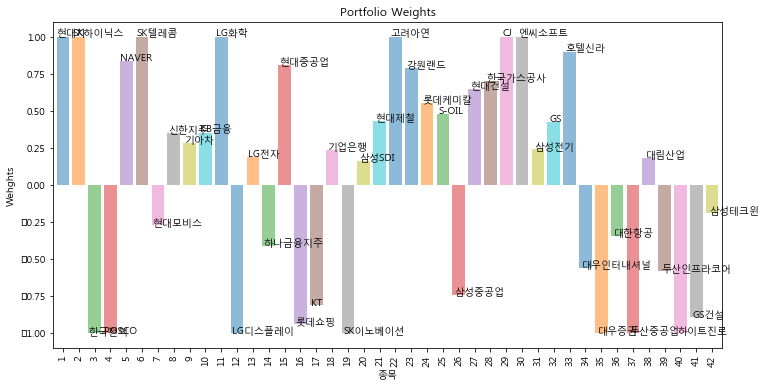

In [62]:
optPortfolio(rtn,C,reg=0) #다음과 같이 포트폴리오를 구성하면 수익률 8.5,변동성 17.2의 종목을 가지고 있는 것과 동일
# 과잉적합문제 발생


* 포트폴리오 수익률 = 191.99 (%)
* 포트폴리오 변동성 = 146.31 (%)
* Sharp Ratio = 1.31


,name,rtn,vol,sr,weight
0,현대차,0.068448,0.371064,0.184463,1.000000
1,SK하이닉스,0.077177,0.458435,0.168349,1.000000
2,한국전력,-0.007090,0.303762,-0.023340,-1.000000
3,POSCO,0.017288,0.340827,0.050723,-1.000000
4,NAVER,0.135453,0.413023,0.327956,0.833189
5,SK텔레콤,0.060193,0.252257,0.238619,1.000000
6,현대모비스,0.085617,0.360533,0.237474,-0.271481
7,신한지주,0.011235,0.338703,0.033172,0.350427
8,기아차,0.097751,0.393640,0.248326,0.286051
9,KB금융,0.014700,0.358154,0.041045,0.353300


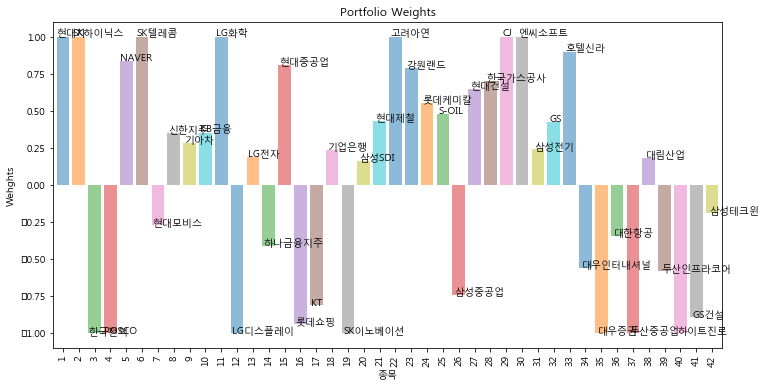

In [63]:
optPortfolio(rtn,C,reg=0)

In [61]:
# minimize [x1 * x4 * (x1 + x2 + x3) + x3]
# s.t. x1 * x2 * x3 * x4 >= 25
#      x1^2 + x2^2 + x3^2 + x4^2 = 40
#      1 <= x1, x2, x3, x4 <= 5
#      x0 = [1, 5, 5, 5]
# reference : https://www.youtube.com/watch?v=cXHvC_FGx24
# -------------------------------------------------------
import scipy.optimize as optimize #optimize: 최적화 도구(수치해석)

def objective(x): #목적함수
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    
    return x1 * x4 * (x1 + x2 + x3) + x3 #단순식계산

def constraint1(x): #제약조건1
    return x[0] * x[1] * x[2] * x[3] - 25.0 #우변을 0으로 만들어준다. 이 식이 0보다 크다고 만들어주기 위해

def constraint2(x):
    sum_sq = 0
    for i in range(4):
        sum_sq += x[i] ** 2
    return sum_sq - 40

x0 = [1, 5, 5, 1] #초기값
print(objective(x0))

b = (1.0, 5.0) #범위 설정
bnds = (b, b, b, b) #([1,5],[1,5],[1,5],[1,5])
con1 = {'type' : 'ineq', 'fun' : constraint1} #ineq:부등식>을 의미 0보다 작을 때는 -로 식을 바꿔줘야함
con2 = {'type' : 'eq', 'fun' : constraint2} #eq: =0
cons = [con1, con2]

sol = optimize.minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons)

print()
print("x1 = %.2f" % sol.x[0])
print("x2 = %.2f" % sol.x[1])
print("x3 = %.2f" % sol.x[2])
print("x4 = %.2f" % sol.x[3])
print("Objective의 최솟값 = %.2f" % sol.fun)


16

x1 = 1.00
x2 = 4.74
x3 = 3.82
x4 = 1.38
Objective의 최솟값 = 17.01
